# Humpback Whale Setup/Preprocessing

This file will contain the github setup for easy collaboration and version control. We will also be performing the basic data exploration and preprocessing for our models.

## Github Connection/Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/cisc867/project/

In [ ]:
# !git config --global user.email "medema.emily@gmail.com"
# !git config --global user.name "emedema"

In [ ]:
# !git status

In [ ]:
# !git add .

In [ ]:
# !git commit -m "adding data in parts - test redone"

In [ ]:
# !git push 

# Bounding Box Generation

Leveraging the weights from a pretrained model, described the same model and import the weights, evaluate the model on images, and save generated bounding box coordinates to a pickle file.

Images and their bounded boxes can be previewed at this [cell](https://colab.research.google.com/drive/1ENRTHsGsaAbGtPA3KlFgpHyFkJz09ekh#scrollTo=Pt3J2ahl_w9i&line=2&uniqifier=1).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/project/

/content/drive/.shortcut-targets-by-id/10mODgOSFf3fLzrw5sXuVWhlwvZyG_SDQ/project


In [4]:
# Suppress stderr output when importing keras.
import sys
old_stderr = sys.stderr
sys.stderr = open('/dev/null', 'w')
import keras
sys.stderr = old_stderr

In [5]:
# import all necessary libraries
from PIL import Image as pil_image
from PIL.ImageDraw import Draw
from os.path import isfile

# function to expand path
def expand_path(p):
    if isfile('data/train/' + p): return 'data/train/' + p
    if isfile('data/test/' + p): return 'data/test/' + p
    return p

def read_raw_image(p):
    return pil_image.open(expand_path(p))

def draw_dot(draw, x, y):
    draw.ellipse(((x-5,y-5),(x+5,y+5)), fill='red', outline='red')

def draw_dots(draw, coordinates):
    for x,y in coordinates: draw_dot(draw, x, y)

def bounding_rectangle(list):
    x0, y0 = list[0]
    x1, y1 = x0, y0
    for x,y in list[1:]:
        x0 = min(x0, x)
        y0 = min(y0, y)
        x1 = max(x1, x)
        y1 = max(y1, y)
    return x0,y0,x1,y1


In [6]:
# Define useful constants
img_shape  = (128,128,1)
anisotropy = 2.15

In [7]:
import random
import numpy as np
from scipy.ndimage import affine_transform
from keras.utils import img_to_array
from keras import backend as K

# Read an image as black&white numpy array
def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

# Compute the coordinate transformation required to center the pictures, padding as required.
def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

# Read an image for validation, i.e. without data augmentation.
def read_for_validation(p):
    x  = read_array(p)
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t 

# Read an image for training, i.e. including a random affine transformation
def read_for_training(p):
    x  = read_array(p)
    t  = build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.9, 1.0),
            random.uniform(0.9, 1.0),
            random.uniform(-0.05*img_shape[0], 0.05*img_shape[0]),
            random.uniform(-0.05*img_shape[1], 0.05*img_shape[1]))
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x,t   

# Transform corrdinates according to the provided affine transformation
def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

In [8]:
# from keras.engine.topology import Input
from keras.layers import BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Model

def build_model(with_dropout=True):
    kwargs     = {'activation':'relu', 'padding':'same'}
    conv_drop  = 0.2
    dense_drop = 0.5
    inp        = Input(shape=img_shape)

    x = inp

    x = Conv2D(64, (9, 9), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    x = Conv2D(64, (2, 2), **kwargs, strides=2)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = Conv2D(64, (3, 3), **kwargs)(x)
    x = BatchNormalization()(x)
    if with_dropout: x = Dropout(conv_drop, noise_shape=(None, 1, 1, int(x.shape[-1])))(x)

    h = MaxPooling2D(pool_size=(1, int(x.shape[2])))(x)
    h = Flatten()(h)
    if with_dropout: h = Dropout(dense_drop)(h)
    h = Dense(16, activation='relu')(h)

    v = MaxPooling2D(pool_size=(int(x.shape[1]), 1))(x)
    v = Flatten()(v)
    if with_dropout: v = Dropout(dense_drop)(v)
    v = Dense(16, activation='relu')(v)

    x = Concatenate()([h,v])
    if with_dropout: x = Dropout(0.5)(x)
    x = Dense(4, activation='linear')(x)
    return Model(inp,x)

model = build_model(with_dropout=True)

In [9]:
model2 = build_model(with_dropout=False)
model2.load_weights("cropping.model")
# model2.summary()

In [10]:
from pandas import read_csv
from tqdm import tqdm, tqdm_notebook

tagged = [p for _,p,_ in read_csv('data/train.csv').to_records()]
# tagged = [p for _,p,_ in read_csv('/content/test.csv').to_records()]
join = tagged
len(join)

25361

In [ ]:
# Comment this out to not evaluate
# from tqdm import tqdm, tqdm_notebook# For other pictures, evaluate the model.
# p2bb = {}
# for p in tqdm_notebook(join):
#     if p not in p2bb:
#         img,trans         = read_for_validation(p)
#         a                 = np.expand_dims(img, axis=0)
#         x0, y0, x1, y1    = model2.predict(a).squeeze()
#         (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
#         p2bb[p]           = (u0, v0, u1, v1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/7960 [00:00<?, ?it/s]

1/1 [==============================] - 1s 588ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 78ms/step


In [11]:
import matplotlib.pyplot as plt
def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

In [12]:
import pickle
# with open('bounding-box-test.pickle', 'wb') as f: pickle.dump(p2bb, f)
with open('bounding-box-train.pickle', 'rb') as f: p2bb = pickle.load(f)

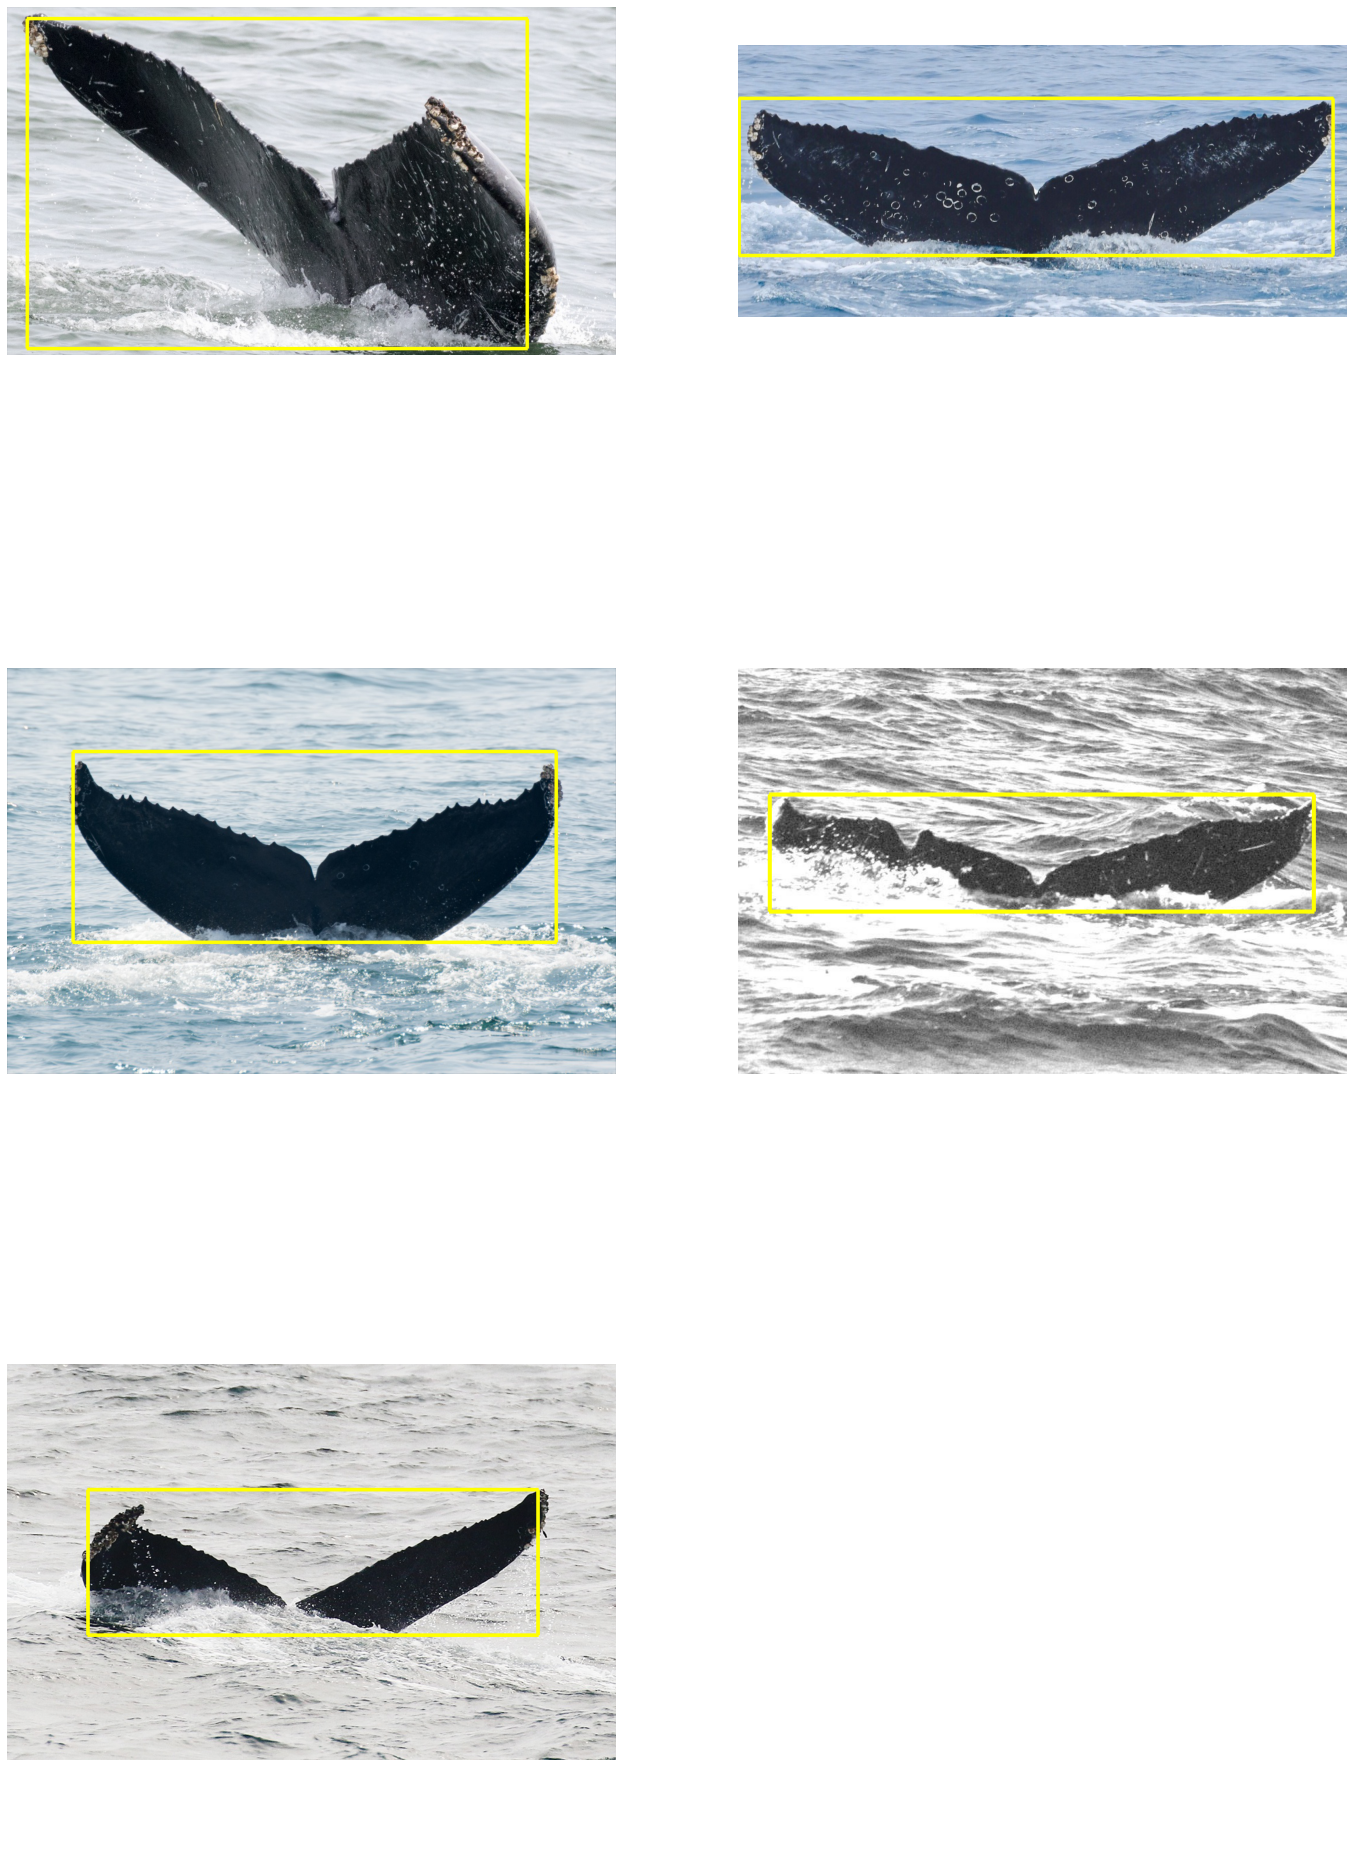

In [13]:
samples = []
for p in tagged[-5:]:
    img         = read_raw_image(p).convert('RGB')
    draw        = Draw(img)
    x0,y0,x1,y1 = p2bb[p]
    draw.line([(x0, y0),(x0,y1),(x1,y1),(x1,y0),(x0,y0)], fill='yellow', width=6)
    samples.append(img)
show_whale(samples)

# Crop and grayscale

In [ ]:
# Determines the size of each image (takes > hour, saving results for future use.)
# from os.path import isfile
# from PIL import Image as pil_image
# from tqdm import tqdm_notebook

# def expand_path(p):
#     if isfile('data/train/' + p): return 'data/train/' + p
#     if isfile('data/test/' + p): return 'data/test/' + p
#     return p

# p2size = {}
# for p in tqdm_notebook(join):
#     size      = pil_image.open(expand_path(p)).size
#     p2size[p] = size
# len(p2size), list(p2size.items())[:5]

# with open('testing_file-sizes.pickle', 'wb') as f: pickle.dump(p2size, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/7960 [00:00<?, ?it/s]

In [14]:
with open('training_file-sizes.pickle', 'rb') as f: p2size = pickle.load(f)
len(p2size), list(p2size.items())[:5]

(25361,
 [('0000e88ab.jpg', (1050, 700)),
  ('0001f9222.jpg', (758, 325)),
  ('00029d126.jpg', (1050, 497)),
  ('00050a15a.jpg', (1050, 525)),
  ('0005c1ef8.jpg', (1050, 525))])

In [15]:
import random
from keras import backend as K
from keras.utils import img_to_array,array_to_img
from scipy.ndimage import affine_transform

img_shape    = (384,384,1)
crop_margin  = 0.08 # The margin added around the bounding box to compensate for bounding box inaccuracy

def read_cropped_image(p):
    """
    @param p : the name of the picture to read
    """
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx
    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

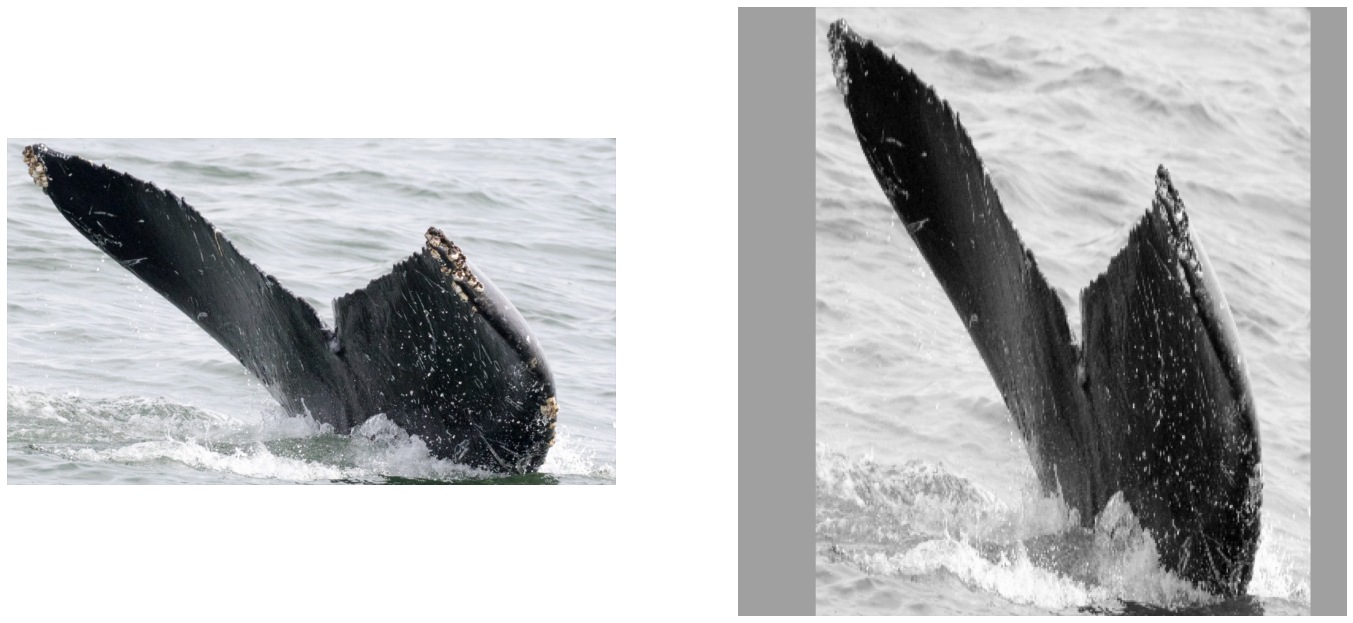

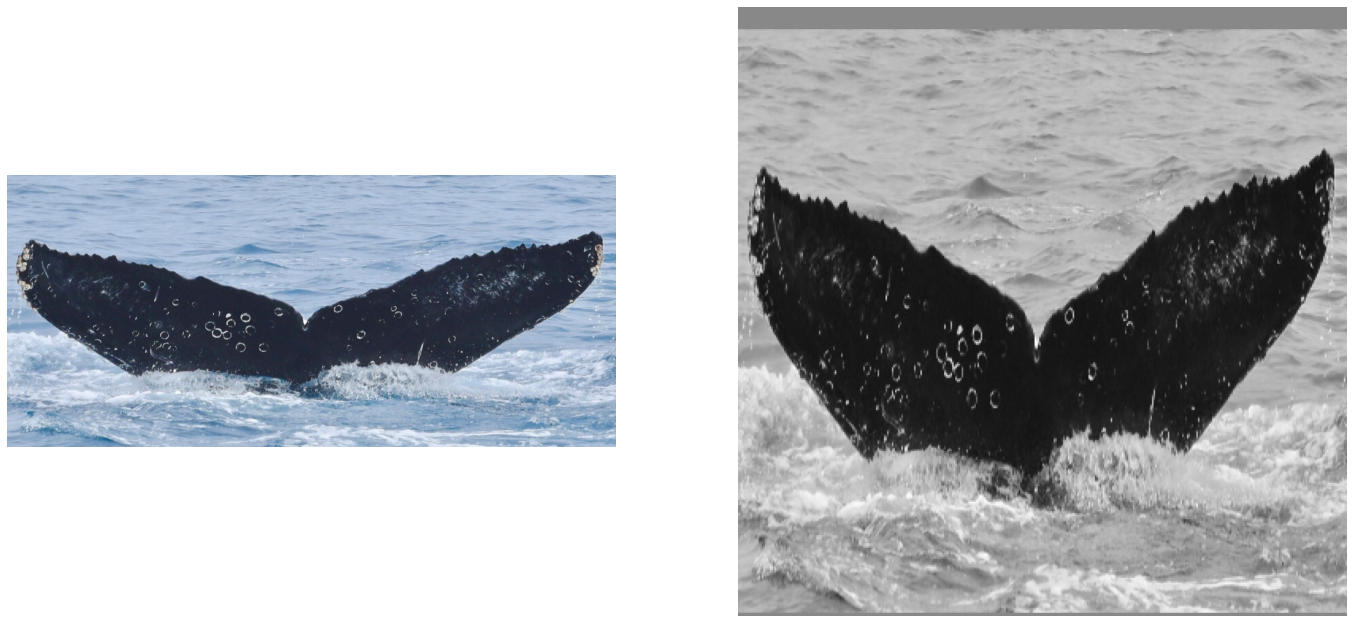

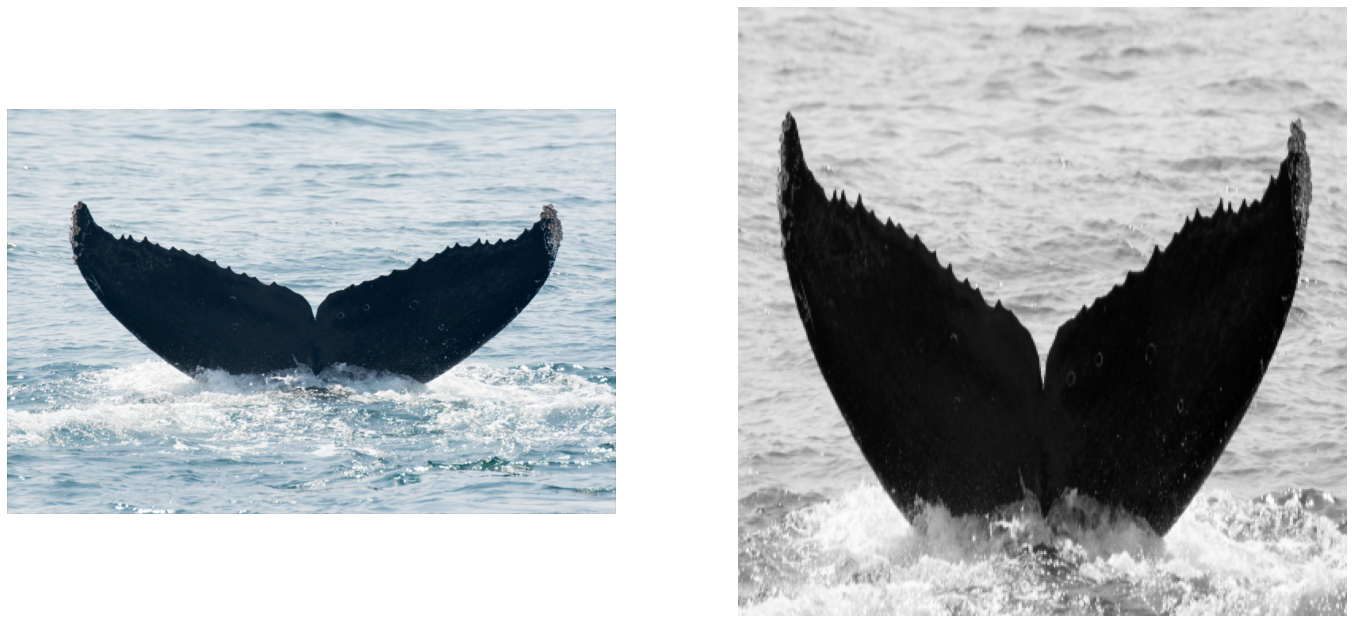

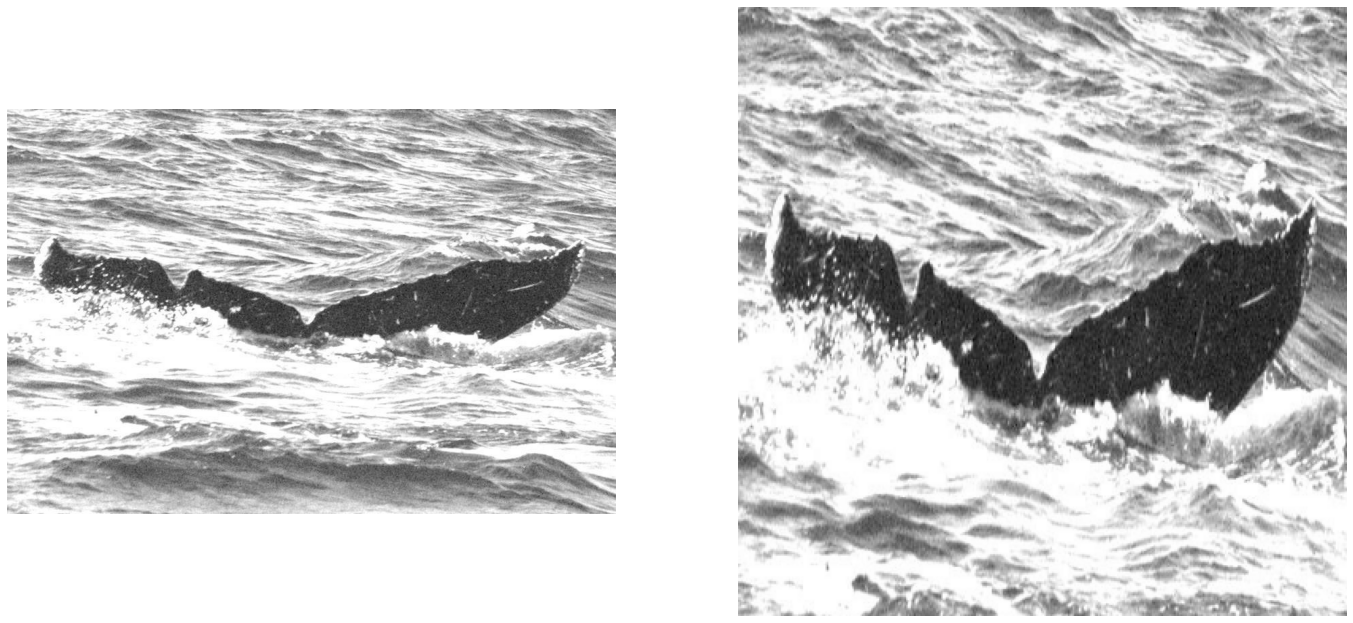

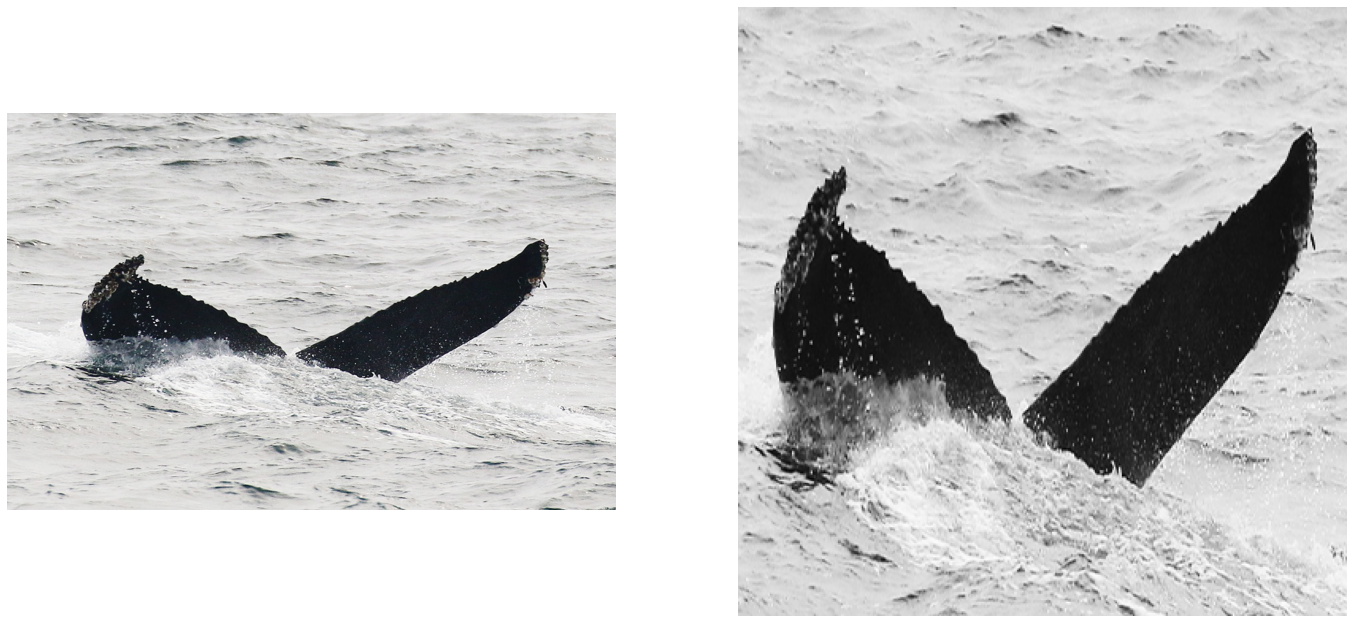

In [16]:
# Testing the image from above whose bounding box didn't capture the entire fluke. Had to increase crop_margin to 0.08
p = list(tagged)
for img in p[-5:]:
  original = read_raw_image(img)
  processed = array_to_img(read_cropped_image(img))
  imgs = [original, processed]
  show_whale(imgs, per_row=2)

In [33]:
len(p)

25361

In [35]:
# Comment this for saving processed images
# import os
# dirList = os.listdir(os.getcwd() + "/data/train_processed")
# p = list(tagged)
# counter = 0
# for img in p:
#   if img not in dirList:
#     processed = array_to_img(read_cropped_image(img))
#     processed.save("data/train_processed/" + img)


In [38]:
import os
dirList = os.listdir(os.getcwd() + "/data/train_processed")
len(dirList)

25361